In [1]:
import cv2
import numpy as np
import os


In [2]:
def load_images_from_folder(folder):
    """Belirtilen klasörden tüm görüntüleri yükleyin ve SIFT özelliklerini çıkarın."""
    images = []
    sift = cv2.SIFT_create()
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            kp, des = sift.detectAndCompute(img, None)
            images.append((filename, des))
    return images

In [29]:
def match_features(des1, des2):
    """İki özellik seti arasındaki eşleşmeleri bulun."""
    # Boş tanımlayıcı kontrolleri
    if des1 is None or des2 is None:
        return 0
    
    # Tanımlayıcıları float32'ye dönüştür
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for match in matches:
        # Her eşleşme listesinin uzunluğunu kontrol et
        if len(match) == 2:
            m, n = match
            if m.distance < 0.62*n.distance:
                good.append(m)
    return len(good)

In [4]:
def classify_image(test_img_path, training_features):
    """Test görüntüsünden SIFT özelliklerini çıkar ve sınıflandır."""
    sift = cv2.SIFT_create()
    img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return "Image not found or unsupported format"
    
    kp, des_test = sift.detectAndCompute(img, None)
    # Test tanımlayıcısının boş olup olmadığını kontrol et
    if des_test is None:
        return "No features found in test image"
    
    best_match = {'class': None, 'matches': 0}
    for class_name, features in training_features.items():
        total_matches = 0
        for _, des_train in features:
            # Eğitim seti tanımlayıcısının boş olup olmadığını kontrol et
            if des_train is not None:
                matches = match_features(des_test, des_train)
                total_matches += matches
        if total_matches > best_match['matches']:
            best_match = {'class': class_name, 'matches': total_matches}

    return best_match['class']

In [5]:
# Eğitim setini yükleyin
training_features = {}
for class_folder in os.listdir(r'C:\Users\halil\Computer Vision Project\GTSRB\crop_dataset\crop_dataset'):
    folder_path = os.path.join(r'C:\Users\halil\Computer Vision Project\GTSRB\crop_dataset\crop_dataset', class_folder)
    training_features[class_folder] = load_images_from_folder(folder_path)


In [13]:
# Örnek bir Test görüntüsünü sınıflandırın
test_img_path = r'C:\Users\halil\Computer Vision Project\GTSRB\test_data\test_data\00001.jpg'
predicted_class = classify_image(test_img_path, training_features)
print(f"Predicted class: {predicted_class}")

Predicted class: 00001


In [36]:
import joblib

# Modeli kaydet
joblib.dump(training_features, 'trained_model.pkl')


['trained_model.pkl']


Recall:
 [0.         0.64444444 0.78666667 0.24       0.47878788 0.53015873
 0.         0.60444444 0.40888889 0.64583333 0.75757576 0.84285714
 0.56231884 0.94027778 0.         0.         0.         0.8
 0.55897436 0.         0.         0.         0.         0.89583333
 0.         0.         0.         0.         0.         0.
 0.43076923 0.         0.66521739 0.         0.        ]

Precision:
 [0.         0.6676259  0.73842303 0.74482759 0.93768546 0.2859589
 0.         0.92832765 0.77637131 0.93093093 0.83194676 0.98060942
 0.91725768 0.6137806  0.         0.         0.         0.91139241
 0.93965517 0.         0.         0.         0.         0.89026915
 0.         0.         0.         0.         0.         0.
 0.63636364 0.         0.79274611 0.         0.        ]




Accuracy: 64.54%




Micro Average Recall: 0.65
Micro Average Precision: 0.65



Macro Average Recall: 0.31
Macro Average Precision: 0.39



Overall Accuracy: 0.65
F1 Score: 0.65


C:\Users\halil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


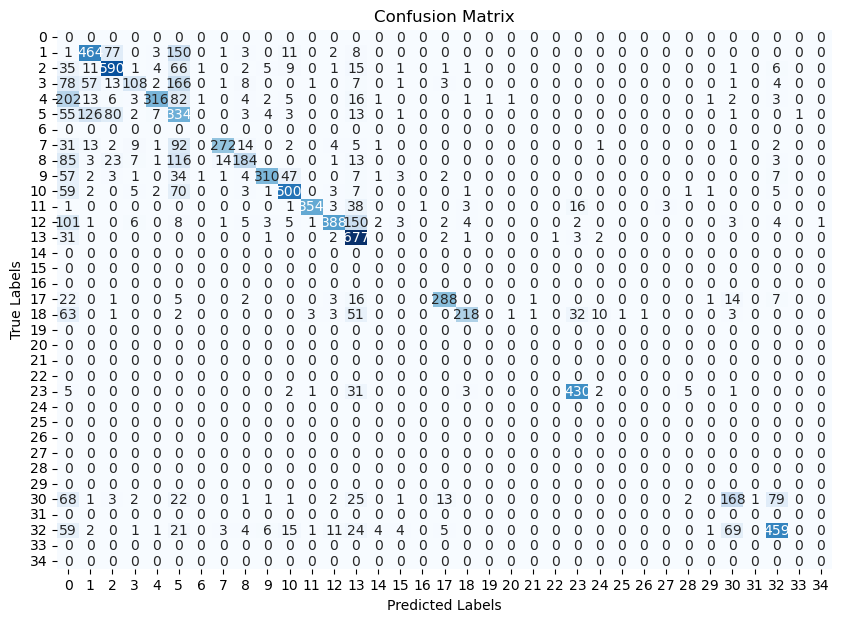

In [35]:
import pandas as pd
import os
import cv2
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# CSV dosyasını oku
test_labels_path = r'C:\Users\halil\Computer Vision Project\GTSRB\fixed_test_label.csv'
test_labels_df = pd.read_csv(test_labels_path)

# Test resimlerinin bulunduğu klasör yolu
test_images_folder = r'C:\Users\halil\Computer Vision Project\GTSRB\test_data\test_data'

# Doğru tahminlerin sayısını sakla
correct_predictions = 0

# Toplam resim sayısı
total_images = len(test_labels_df)

# Actual and predicted classes
actual_classes = np.array([])
predicted_classes = np.array([])

# Test resimleri üzerinde döngü
for index, row in test_labels_df.iterrows():
    image_path = os.path.join(test_images_folder, row['image'])
    
    image = cv2.imread(image_path)

    # image'ı classify_image() fonksiyonuna geçir
    predicted_class = classify_image(image_path, training_features)
    
    if predicted_class == 'No features found in test image':
        predicted_class = -1
    
    if predicted_class is None:
        predicted_class = -1


    # ROI üzerinde sınıflandırma yapmak için mevcut kodunuzun sınıflandırma kısmını kullanın

    actual_class = row['label']
    

    actual_classes = np.append(actual_classes, actual_class)
    predicted_classes = np.append(predicted_classes, predicted_class)
    
    # Tahmin edilen sınıf ile gerçek sınıfı karşılaştır
    if predicted_class == actual_class:
        correct_predictions += 1

# Metrikleri Hesaplama
actual_classes = actual_classes.astype(int)
predicted_classes = predicted_classes.astype(int)
conf_matrix = confusion_matrix(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes, average=None, zero_division=0)
precision = precision_score(actual_classes, predicted_classes, average=None, zero_division=0)
accuracy = accuracy_score(actual_classes, predicted_classes)

# Sonuçları yazdır
print(f"\nRecall:\n {recall}")
print(f"\nPrecision:\n {precision}")
print(f"\n\n\n\nAccuracy: {accuracy:.2%}")

# Micro average ile genel recall, precision ve accuracy hesaplama
recall_micro = recall_score(actual_classes, predicted_classes, average='micro')
precision_micro = precision_score(actual_classes, predicted_classes, average='micro')
accuracy_micro = accuracy_score(actual_classes, predicted_classes)

# Macro average ile genel recall ve precision hesaplama
recall_macro = recall_score(actual_classes, predicted_classes, average='macro')
precision_macro = precision_score(actual_classes, predicted_classes, average='macro')
f1_score = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)

print(f"\n\n\n\nMicro Average Recall: {recall_micro:.2f}")
print(f"Micro Average Precision: {precision_micro:.2f}")
print(f"\n\n\nMacro Average Recall: {recall_macro:.2f}")
print(f"Macro Average Precision: {precision_macro:.2f}")
print(f"\n\n\nOverall Accuracy: {accuracy_micro:.2f}")
print(f"F1 Score: {f1_score:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
